
[Dati nuovi](http://localhost:8888/notebooks/Documenti/TESI/thesis/codici/Notebook%20Completi/Hough%20TF.ipynb#solo-Hough-dati-nuovi)

[Programma debug](http://localhost:8888/notebooks/Documenti/TESI/thesis/codici/Notebook%20Completi/Hough%20TF.ipynb#Programma-test-semplice)

[Dati OLD TEST](http://localhost:8888/notebooks/Documenti/TESI/thesis/codici/Notebook%20Completi/Hough%20TF.ipynb#Dati-OLD)

[Dati Federico](http://localhost:8888/notebooks/Documenti/TESI/thesis/codici/Notebook%20Completi/Hough%20TF.ipynb#Dati-Federico)

## solo Hough dati nuovi

In [1]:
import tensorflow as tf
import numpy
import scipy.io
#from tensorflow.python.client import timeline
import time

#percorsoDati = "/home/protoss/Documenti/TESI/DATI/dati9mesi108HWI.mat"
#percorsoDati = "/home/protoss/Documenti/TESI/DATI/datiOLDmesi108HWI.mat"
percorsoDati = "/home/protoss/Documenti/TESI/DATI/dati9mesi187HWI.mat"

#tFft = 8192
tFft = 4096
tObs = 9 #mesi
tObs = tObs*30*24*60*60

#carico file dati
struttura = scipy.io.loadmat(percorsoDati)['job_pack_0']

#peakmap = struttura['peaks'][0,0]
#print(peakmap)
#tempiIndiciSorted = numpy.argsort(peakmap[0,:])
#tempi = peakmap[0, tempiIndiciSorted]
#frequenze = peakmap[1, tempiIndiciSorted]
#pesi =peakmap[4, tempiIndiciSorted] + 1 #numpy.ones(peakmap[4].size)#

#print(tempi)
#print(frequenze)
#print(pesi)

tempi = struttura['peaks'][0,0][0]#.astype(numpy.float32)
frequenze = struttura['peaks'][0,0][1]#.astype(numpy.float32)
pesi = (struttura['peaks'][0,0][4]+1)#.astype(numpy.float32)

primoTempo = struttura['basic_info'][0,0]['tim0'][0,0][0,0]

print(primoTempo, numpy.amin(tempi),numpy.amax(tempi))

57722 57722.7079514 57989.9909028


In [2]:

#nb: picchi ha 0-tempi
#              1-frequenze
#              2-pesi

#headers vari
securbelt = 4000


#frequenze
#frequenze
stepFrequenza = 1/tFft
enhancement = 10
stepFreqRaffinato =  stepFrequenza/enhancement

freqMin = numpy.amin(frequenze)
freqMax = numpy.amax(frequenze)
freqIniz = freqMin- stepFrequenza/2 - stepFreqRaffinato
freqFin = freqMax + stepFrequenza/2 + stepFreqRaffinato
nstepFrequenze = numpy.ceil((freqFin-freqIniz)/stepFreqRaffinato)+securbelt

#tempi
#epoca definita come mediana di tempi di tutto il run
epoca = #(57722+57990)/2 #0
#epoca = 0

# riarrangio gli array in modo che abbia i dati 
# nel formato che voglio io
print(tempi)
print(frequenze)

frequenze = frequenze-freqIniz
frequenze = (frequenze/stepFreqRaffinato)-round(enhancement/2+0.001)

tempi = tempi-numpy.amin(tempi)

tempi = ((tempi)*3600*24/stepFreqRaffinato)
print(numpy.amax(numpy.unique(tempi)))
#tempi = numpy.round(tempi/1e8)*1e8


#spindowns
spindownMin = -1e-9
spindownMax = 1e-10
stepSpindown = stepFrequenza/tObs 

nstepSpindown = numpy.round((spindownMax-spindownMin)/stepSpindown).astype(numpy.int64)


spindowns = numpy.arange(0, nstepSpindown)
spindowns = numpy.multiply(spindowns,stepSpindown)
spindowns = numpy.add(spindowns, spindownMin)


[ 57722.70795139  57722.70795139  57722.70795139 ...,  57989.99090278
  57989.99090278  57989.99090278]
[ 186.96362305  186.96459961  186.96557617 ...,  191.8984375   191.95117188
  192.00073242]
945899397120.0


In [3]:
# così ho i tre array delle tre grandezze, più i pesi e la fascia di sicurezza
#ora uso Tensorflow
securbeltTF = tf.constant(securbelt,dtype=tf.float32)
tempiTF = tf.constant(tempi,dtype=tf.float32)
pesiTF = tf.constant(pesi,dtype=tf.float32)
spindownsTF = tf.constant(spindowns, dtype=tf.float32)
frequenzeTF = tf.constant(frequenze, dtype=tf.float32)

nRows = tf.constant(nstepSpindown, dtype=tf.int32)
nColumns = nstepFrequenze

pesiTF = tf.reshape(pesiTF,(1,tf.size(pesi)))
pesiTF = pesiTF[0]

def mapnonVar(stepIesimo):
    sdTimed = tf.multiply(spindownsTF[stepIesimo], tempiTF, name = "Tdotpert")
    #sdTimed = tf.cast(sdTimed, dtype=tf.float32)
    
    appoggio = tf.round(frequenzeTF-sdTimed+securbeltTF/2, name = "appoggioperindici")
    appoggio = tf.cast(appoggio, dtype=tf.int32)
    
    valori = tf.unsorted_segment_sum(pesiTF, appoggio, nColumns)
    return valori

def mapbincount(stepIesimo):
    sdTimed = tf.multiply(spindownsTF[stepIesimo], tempi, name = "Tdotpert")
    #sdTimed = tf.cast(sdTimed, dtype=tf.float32)
    
    appoggio = tf.round(frequenzeTF-sdTimed+securbeltTF/2, name = "appoggioperindici")
    appoggio = tf.cast(appoggio, dtype=tf.int32)
    
    valori = tf.bincount(appoggio,weights=pesiTF)

    zeriDopo = tf.zeros([nColumns - tf.size(valori)], dtype=tf.float64)
    
    riga = tf.concat([valori,zeriDopo],0, name = "rigadihough")
    return riga


imagenonVar = tf.map_fn(mapnonVar, tf.range(0, nRows), dtype=tf.float32, parallel_iterations=8)
#imagenonVar = tf.map_fn(mapbincount, tf.range(0, nRows), dtype=tf.float32, parallel_iterations=8)




sessione = tf.Session()


start = time.time()
image = sessione.run(imagenonVar)
stop = time.time()
print(stop-start)



nColumns = nColumns.astype(int)
semiLarghezza = numpy.round(enhancement/2+0.001).astype(int)
image[:,semiLarghezza*2:nColumns]=image[:,semiLarghezza*2:nColumns]-image[:,0:nColumns - semiLarghezza*2]
image = numpy.cumsum(image, axis = 1)

14.785930871963501


In [4]:
from matplotlib import pyplot
%matplotlib qt
pyplot.figure(figsize=(10, 8))
a = pyplot.imshow(image, aspect = 250)
#a = pyplot.imshow(image[94:98], aspect = 10000)
pyplot.colorbar(shrink = 1,aspect = 10)
#a = pyplot.imshow(image[191:192], aspect = 10000)
pyplot.show()
#
#DA METTER IN LOG

#### on gpu wn100 0.2892894744873047
# $\;$



imshow colormaps: https://matplotlib.org/examples/color/colormaps_reference.html

In [36]:
#confronto con originale

percorsoFile = "/home/protoss/wn100bkp/dati/confronto/hough52HWINONCOR.mat"
#percorsoFile2 = "originale/senzacumsum.mat"
immagineOriginale = scipy.io.loadmat(percorsoFile)['binh_df0ORIG']
#immagineOrignoncumsum = scipy.io.loadmat(percorsoFile2)['binh_df0']

#percorsoFile = "debugExamples/concumsumDB.mat"
#imgOrigDB = scipy.io.loadmat(percorsoFile)['binh_df0']



In [8]:
from matplotlib import pyplot
%matplotlib qt
pyplot.figure(figsize=(10, 8))

#pyplot.figure(figsize=(100, 30))
pyplot.imshow(immagineOriginale,
              #cmap='gray',
              aspect=250)
pyplot.colorbar(shrink = 1,aspect = 10)
#pyplot.colorbar(immagine)

In [37]:
miaVSoriginale = (image - immagineOriginale)
#miaVSoriginale = immagineOriginale - imageParalled
#matlabVSoriginale = immagineOriginale - imgOrigDB

from matplotlib import pyplot
%matplotlib notebook
pyplot.figure(figsize=(10, 8))

#verificadoppia = miaVSoriginale - matlabVSoriginale
pyplot.imshow(miaVSoriginale,aspect=250)
pyplot.colorbar(shrink = 1,aspect = 10)
print(numpy.nonzero(miaVSoriginale[0]))
pyplot.show()

(array([ 1058,  1059,  1060, ..., 87536, 87537, 87538]),)


## Programma test semplice

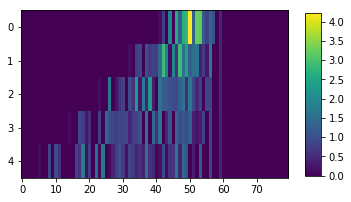

In [1]:
#programma semplificato per test e debug
import numpy
import tensorflow as tf
from tensorflow.python.client import timeline
from matplotlib import pyplot

#first i build a matrix of some x positions vs time datas in a sparse format
matrix = numpy.random.randint(2, size = 100).astype(float).reshape(10,10)

x = numpy.nonzero(matrix)[0]
times = numpy.nonzero(matrix)[1]
weights = numpy.random.rand(x.size)

#then i define an array of y positions
nStepsY = 5
y = numpy.arange(1,nStepsY+1)

#this is only an example, in my work these arrays are the input
#from a file or a preceding function

nRows = nStepsY
nColumns = 80

x = tf.constant(x, dtype = tf.float32)
times = tf.constant(times, dtype = tf.float32)
weights = tf.constant(weights, dtype = tf.float32)
y = tf.constant(y, dtype = tf.float32)


def itermatrix(ithStep):
    yTimed = tf.multiply(y[ithStep],times)

    positions = tf.round((x-yTimed)+50)
    positions = tf.cast(positions, dtype=tf.int32)

    values = tf.unsorted_segment_sum(weights, positions, nColumns)

    return values


def mapbincount(ithStep):
    yTimed = tf.multiply(y[ithStep],times)

    positions = tf.round((x-yTimed)+50)
    positions = tf.cast(positions, dtype=tf.int32)
    
    values = tf.bincount(positions,weights=weights)

    zeriDopo = tf.zeros([nColumns - tf.size(values)], dtype=tf.float64)
    
    riga = tf.concat([valori,zeriDopo],0, name = "rigadihough")
    return riga

def rowTransform(ithStep):
    sdTimed = spindowns[ithStep]*times
    transform = (numpy.round(frequencies-sdTimed+PAR_secbelt/2)).astype(int)
    #values = numpy.zeros(nColumns)
    values = numpy.bincount(transform,weights)
    zeriDopo = tf.zeros([nColumns - values.size])
    row = numpy.concatenate([values,zeriDopo],0)
    return row

    # definition of the TensorFlow variable and values assignment with tf.map_fn
    houghLeft = numpy.zeros([nRows, nColumns])
    for i in numpy.arange(nRows):
        houghLeft[i] = rowTransform(i)


imageMapped = tf.map_fn(itermatrix, tf.range(0,nRows), dtype=tf.float32)

sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))

run_options = tf.RunOptions(trace_level=tf.RunOptions.FULL_TRACE)
run_metadata = tf.RunMetadata()

image = sess.run(imageMapped, options=run_options, run_metadata=run_metadata)

    # Create the Timeline object, and write it to a json
tl = timeline.Timeline(run_metadata.step_stats)
ctf = tl.generate_chrome_trace_format()
with open('timelineDB.json', 'w') as f:
	f.write(ctf)

%matplotlib inline
pyplot.imshow(image, aspect = 10)
pyplot.colorbar(shrink = 0.75,aspect = 10)

In [ ]:
#programma semplificato per test e debug
import numpy
import tensorflow as tf
from tensorflow.python.client import timeline
from matplotlib import pyplot

#first i build a matrix of some x positions vs time datas in a sparse format
matrix = numpy.random.randint(2, size = 100).astype(float).reshape(10,10)

x = numpy.nonzero(matrix)[0]
times = numpy.nonzero(matrix)[1]
weights = numpy.random.rand(x.size)

#then i define an array of y positions
nStepsY = 5
y = numpy.arange(1,nStepsY+1)

#this is only an example, in my work these arrays are the input
#from a file or a preceding function

nRows = nStepsY
nColumns = 80

x = tf.constant(x, dtype = tf.float32)
times = tf.constant(times, dtype = tf.float32)
weights = tf.constant(weights, dtype = tf.float32)
y = tf.constant(y, dtype = tf.float32)

def rowTransform(ithStep):
    sdTimed = spindowns[ithStep]*times
    transform = (numpy.round(frequencies-sdTimed+PAR_secbelt/2)).astype(int)
    #values = numpy.zeros(nColumns)
    values = numpy.bincount(transform,weights)
    zeriDopo = tf.zeros([nColumns - values.size])
    row = numpy.concatenate([values,zeriDopo],0)
    return row

    # definition of the TensorFlow variable and values assignment with tf.map_fn
    houghLeft = numpy.zeros([nRows, nColumns])

for i in numpy.arange(nRows):
    houghLeft[i] = rowTransform(i)


image = sess.run(imageMapped, options=run_options, run_metadata=run_metadata)

    # Create the Timeline object, and write it to a json
tl = timeline.Timeline(run_metadata.step_stats)
ctf = tl.generate_chrome_trace_format()
with open('timelineDB.json', 'w') as f:
	f.write(ctf)

%matplotlib inline
pyplot.imshow(image, aspect = 10)
pyplot.colorbar(shrink = 0.75,aspect = 10)

## Dati OLD

In [33]:
import tensorflow as tf
import numpy
import scipy.io
import pandas
import os
from tensorflow.python.client import timeline
import time


#carico file dati
percorsoFile = "/home/protoss/Documenti/TESI/DATI/peaks.mat"

#print(picchi.shape)
#picchi[0]
#nb: picchi ha 0-tempi
#              1-frequenze
#              4-pesi

#ora popolo il dataframe
tabella = pandas.DataFrame(scipy.io.loadmat(percorsoFile)['PEAKS'])
tabella.drop(tabella.columns[[2, 3]], axis = 1, inplace=True)
tabella.columns = ["tempi", "frequenze","pesi"]

#fascia di sicurezza
securbelt = 4000

headerFreq= scipy.io.loadmat(percorsoFile)['hm_job'][0,0]['fr'][0]
headerSpindown = scipy.io.loadmat(percorsoFile)['hm_job'][0,0]['sd'][0]
epoca = scipy.io.loadmat(percorsoFile)['basic_info'][0,0]['epoch'][0,0]

#nb: headerFreq ha 0- freq minima,
#                  1- step frequenza, 
#                  2- enhancement in risoluzone freq, 
#                  3- freq massima, 
#headerSpindown ha 0- spin down iniziale di pulsar
#                  1- step spindown
#                  2- numero di step di spindown
#Definisco relative variabili per comodità e chiarezza del codice

#frequenze
minFreq = headerFreq[0]
maxFreq = headerFreq[3]
enhancement = headerFreq[2]
stepFrequenza = headerFreq[1]
stepFreqRaffinato = stepFrequenza/enhancement

freqIniz = minFreq- stepFrequenza/2 - stepFreqRaffinato
freqFin = maxFreq + stepFrequenza/2 + stepFreqRaffinato
nstepFrequenze = numpy.ceil((freqFin-freqIniz)/stepFreqRaffinato)+securbelt

#spindown
spindownIniz = headerSpindown[0]
stepSpindown = headerSpindown[1]
#nstepSpindown = 200
nstepSpindown = headerSpindown[2].astype(int)


# riarrangio gli array in modo che abbia i dati 
# nel formato che voglio io
frequenze = tabella['frequenze'].values
frequenze = ((frequenze-freqIniz)/stepFreqRaffinato)-round(enhancement/2+0.001)

tempi = tabella['tempi'].values
tempi = tempi-epoca
tempi = ((tempi)*3600*24/stepFreqRaffinato)
#tempi = tempi - numpy.amin(tempi)+1
#tempi = tempi.astype(int)

print(minFreq, maxFreq, numpy.amin(tempi), numpy.amax(tempi))
print(maxFreq-minFreq, (numpy.amax(tempi)-numpy.amin(tempi))/1e11)

pesi = tabella['pesi'].values

#%reset_selective tabella

#nstepSpindown = 85
spindowns = numpy.arange(0, nstepSpindown)
spindowns = numpy.multiply(spindowns,stepSpindown)
spindowns = numpy.add(spindowns, spindownIniz)

# così ho i tre array delle tre grandezze, più i pesi e la fascia di sicurezza
#ora uso Tensorflow
securbeltTF = tf.constant(securbelt,dtype=tf.float32)
tempiTF = tf.constant(tempi,dtype=tf.float32)
pesiTF = tf.constant(pesi,dtype=tf.float32)
spindownsTF = tf.constant(spindowns, dtype=tf.float32)
frequenzeTF = tf.constant(frequenze, dtype=tf.float32)

nRows = tf.constant(nstepSpindown, dtype=tf.int32)
nColumns = nstepFrequenze

pesiTF = tf.reshape(pesiTF,(1,tf.size(pesi)))
pesiTF = pesiTF[0]

#Version con bincount, va leggermente più veloce su cpu ma 
#attualmente non ha supporto gpu
def mapbincount(stepIesimo):
    sdTimed = tf.multiply(spindowns[stepIesimo], tempi, name = "Tdotpert")
    #sdTimed = tf.cast(sdTimed, dtype=tf.float32)
    
    appoggio = tf.round(frequenze-sdTimed+securbelt/2, name = "appoggioperindici")
    appoggio = tf.cast(appoggio, dtype=tf.int32)
    
    valori = tf.bincount(appoggio,weights=pesi)

    zeriDopo = tf.zeros([nColumns - tf.size(valori)], dtype=tf.float32)
    
    riga = tf.concat([valori,zeriDopo],0, name = "rigadihough")
    return riga

def mapnonVar(stepIesimo):
    sdTimed = tf.multiply(spindownsTF[stepIesimo], tempiTF, name = "Tdotpert")
    #sdTimed = tf.cast(sdTimed, dtype=tf.float32)
    
    appoggio = tf.round(frequenzeTF-sdTimed+securbeltTF/2, name = "appoggioperindici")
    appoggio = tf.cast(appoggio, dtype=tf.int32)
    
    valori = tf.unsorted_segment_sum(pesiTF, appoggio, nColumns)

#    zeriDopo = tf.zeros([nColumns - tf.size(valori)], dtype=tf.float32)    
#    riga = tf.concat([valori,zeriDopo],0, name = "rigadihough")
    return valori

imagenonVar = tf.map_fn(mapnonVar, tf.range(0, nRows), dtype=tf.float32, parallel_iterations=8)

#sessione = tf.Session(config=tf.ConfigProto(log_device_placement=True))
sessione = tf.Session()

#run_options = tf.RunOptions(trace_level=tf.RunOptions.FULL_TRACE)
#run_metadata = tf.RunMetadata()

start = time.time()
#image = sessione.run(imagenonVar, options=run_options, run_metadata=run_metadata)
image = sessione.run(imagenonVar)
stop = time.time()
print(stop-start)


    # Create the Timeline object, and write it to a json
#tl = timeline.Timeline(run_metadata.step_stats)
#ctf = tl.generate_chrome_trace_format()
#with open('timelinenonVar.json', 'w') as f:
#	f.write(ctf)

nColumns = nColumns.astype(int)
semiLarghezza = numpy.round(enhancement/2+0.001).astype(int)
image[:,semiLarghezza*2:nColumns]=image[:,semiLarghezza*2:nColumns]-image[:,0:nColumns - semiLarghezza*2]
image = numpy.cumsum(image, axis = 1)

40.0 41.2 -207497483551.0 162260232929.0
1.2 3.6975771648
2.257950782775879
